# Notebook 02: Visualización de Experimentos

Este notebook genera las gráficas para documentar los resultados de los experimentos de la Fase 1.

**Gráficas generadas:**
1. Comparación de F1-scores entre modelos
2. Varianza explicada por PCA
3. Proyección PCA 2D
4. Scores de SelectKBest
5. Feature importance (XGBoost/LightGBM)
6. Matrices de confusión

In [1]:
import sys
import os
from pathlib import Path

# Configuración del proyecto - obtener directorio raíz del proyecto
# El notebook está en notebooks/, el proyecto está un nivel arriba
PROJECT_ROOT = Path(os.getcwd()).parent if Path(os.getcwd()).name == 'notebooks' else Path(os.getcwd())
sys.path.insert(0, str(PROJECT_ROOT))
print(f'PROJECT_ROOT: {PROJECT_ROOT}')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from src.preprocessing import load_data, prepare_features, scale_features, apply_pca, select_k_best
from src.models import evaluate_model_cv

# Paths
DATA_PATH = PROJECT_ROOT / 'data'
GRAFICAS_PATH = PROJECT_ROOT / 'docs' / 'graficas'
RANDOM_STATE = 42

print("✓ Librerías cargadas correctamente")

PROJECT_ROOT: c:\Users\the_y\OneDrive\Escritorio\UNI\4º\1er cuatrimestre\IN\Practicas\P3
✓ Librerías cargadas correctamente


## 1. Carga de Datos

In [2]:
# Cargar datos
train_df, test_df = load_data(DATA_PATH / 'train.csv', DATA_PATH / 'test.csv')
X_train, X_test, y_train, feature_cols = prepare_features(train_df, test_df)
X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)

print(f"Muestras de entrenamiento: {X_train.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Distribución de clases: {dict(zip(*np.unique(y_train, return_counts=True)))}")

Muestras de entrenamiento: 336
Features: 304
Distribución de clases: {np.int64(0): np.int64(140), np.int64(1): np.int64(196)}


## 2. Evaluación de Modelos

In [3]:
results = []

# Exp01: Baseline
m, s, _ = evaluate_model_cv(LogisticRegression(max_iter=1000, random_state=42), X_train_scaled, y_train)
results.append({'Experimento': 'Exp01: Baseline LR', 'F1_Mean': m, 'F1_Std': s})
print(f"Exp01 - Baseline LR: F1 = {m:.4f} (+/- {s:.4f})")

# Exp02: PCA(3) + LR
X_pca3, _, pca3 = apply_pca(X_train_scaled, X_test_scaled, n_components=3)
m, s, _ = evaluate_model_cv(LogisticRegression(max_iter=1000, random_state=42), X_pca3, y_train)
results.append({'Experimento': 'Exp02: PCA(3) + LR', 'F1_Mean': m, 'F1_Std': s})
print(f"Exp02 - PCA(3) + LR: F1 = {m:.4f} (+/- {s:.4f})")

# Exp03: PCA(7) + XGBoost
X_pca7, _, pca7 = apply_pca(X_train_scaled, X_test_scaled, n_components=7)
m, s, _ = evaluate_model_cv(XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss'), X_pca7, y_train)
results.append({'Experimento': 'Exp03: PCA(7) + XGB', 'F1_Mean': m, 'F1_Std': s})
print(f"Exp03 - PCA(7) + XGB: F1 = {m:.4f} (+/- {s:.4f})")

# Exp04: SelectKBest(50) + RF
X_kb, _, selector = select_k_best(X_train_scaled, X_test_scaled, y_train, k=50)
m, s, _ = evaluate_model_cv(RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42), X_kb, y_train)
results.append({'Experimento': 'Exp04: SKB(50) + RF', 'F1_Mean': m, 'F1_Std': s})
print(f"Exp04 - SKB(50) + RF: F1 = {m:.4f} (+/- {s:.4f})")

# Exp05: XGBoost
m, s, _ = evaluate_model_cv(XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss'), X_train_scaled, y_train)
results.append({'Experimento': 'Exp05: XGBoost', 'F1_Mean': m, 'F1_Std': s})
print(f"Exp05 - XGBoost: F1 = {m:.4f} (+/- {s:.4f})")

# Exp06: LightGBM
m, s, _ = evaluate_model_cv(LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1), X_train_scaled, y_train)
results.append({'Experimento': 'Exp06: LightGBM', 'F1_Mean': m, 'F1_Std': s})
print(f"Exp06 - LightGBM: F1 = {m:.4f} (+/- {s:.4f})")

results_df = pd.DataFrame(results)
results_df

Exp01 - Baseline LR: F1 = 0.8278 (+/- 0.0232)
Exp02 - PCA(3) + LR: F1 = 0.7368 (+/- 0.0020)
Exp03 - PCA(7) + XGB: F1 = 0.7268 (+/- 0.0508)
Exp04 - SKB(50) + RF: F1 = 0.6802 (+/- 0.0544)
Exp05 - XGBoost: F1 = 0.7472 (+/- 0.0520)
Exp06 - LightGBM: F1 = 0.7232 (+/- 0.0556)


,Experimento,F1_Mean,F1_Std
0,Exp01: Baseline LR,0.827817,0.023247
1,Exp02: PCA(3) + LR,0.736827,0.001957
2,Exp03: PCA(7) + XGB,0.726757,0.050840
3,Exp04: SKB(50) + RF,0.680226,0.054365
4,Exp05: XGBoost,0.747242,0.051996
5,Exp06: LightGBM,0.723244,0.055620


## 3. Gráfica: Comparación de Modelos

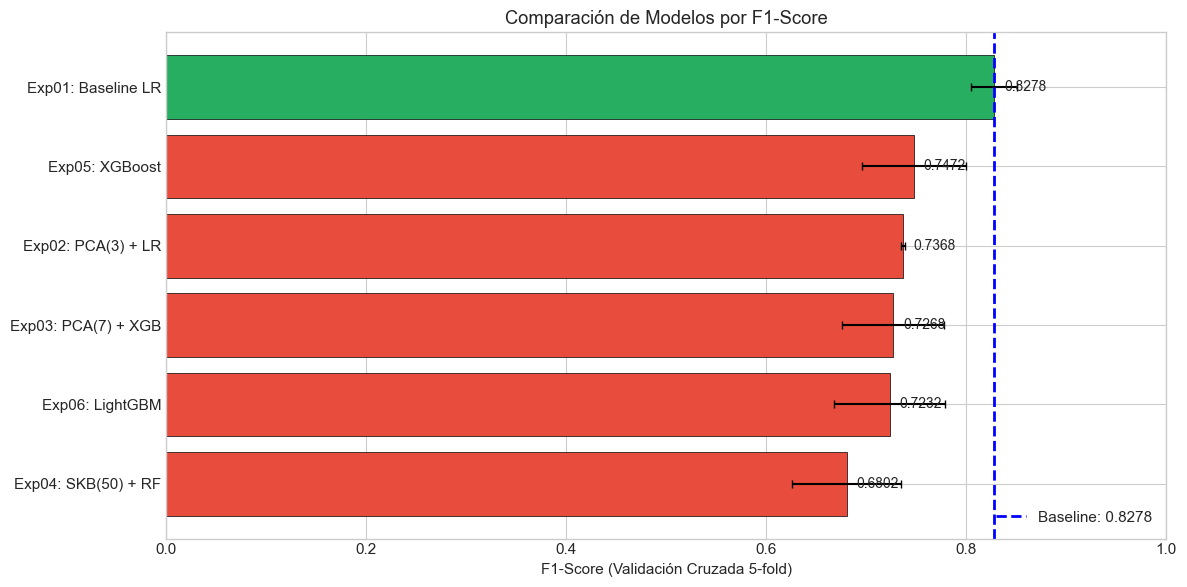

✓ Guardada: comparacion_modelos_fase1.png


In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

results_sorted = results_df.sort_values('F1_Mean', ascending=True)
colors = ['#e74c3c' if x < 0.75 else '#f39c12' if x < 0.8 else '#27ae60' for x in results_sorted['F1_Mean']]

bars = ax.barh(results_sorted['Experimento'], results_sorted['F1_Mean'], color=colors, edgecolor='black', linewidth=0.5)
ax.errorbar(results_sorted['F1_Mean'], results_sorted['Experimento'], xerr=results_sorted['F1_Std'], fmt='none', color='black', capsize=3)

for bar, score in zip(bars, results_sorted['F1_Mean']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center', fontsize=10)

baseline_score = results_df[results_df['Experimento'].str.contains('Baseline')]['F1_Mean'].values[0]
ax.axvline(x=baseline_score, color='blue', linestyle='--', linewidth=2, label=f'Baseline: {baseline_score:.4f}')

ax.set_xlabel('F1-Score (Validación Cruzada 5-fold)')
ax.set_title('Comparación de Modelos por F1-Score')
ax.set_xlim(0, 1)
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig(GRAFICAS_PATH / 'comparacion_modelos_fase1.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Guardada: comparacion_modelos_fase1.png")

## 4. Gráfica: Varianza Explicada por PCA

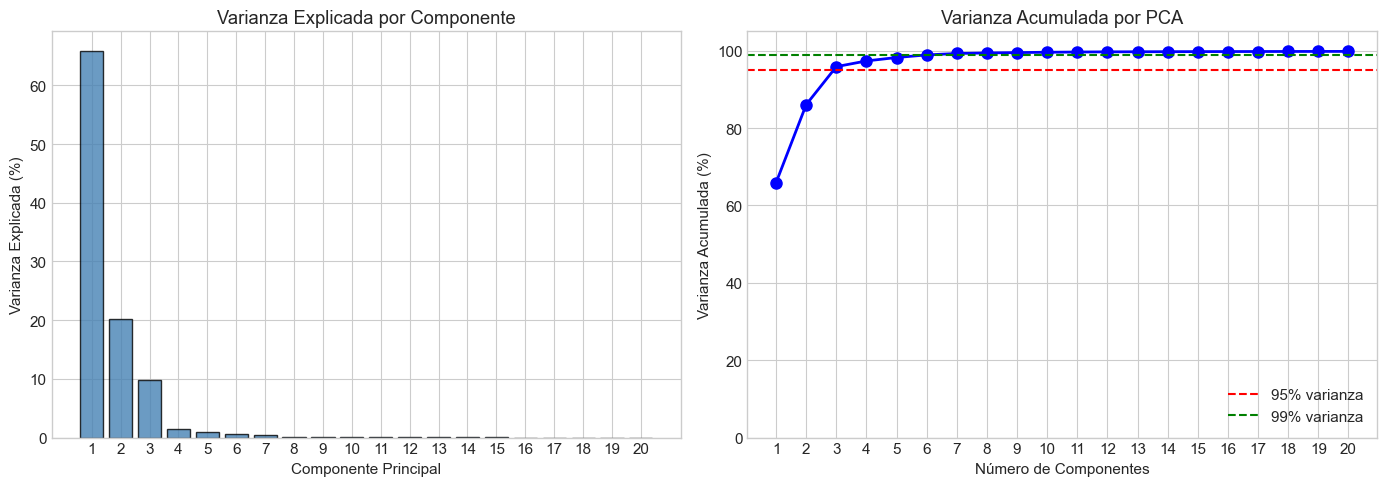

✓ Guardada: pca_varianza_explicada.png


In [5]:
pca_full = PCA(n_components=20, random_state=RANDOM_STATE)
pca_full.fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Varianza individual
ax1.bar(range(1, 21), pca_full.explained_variance_ratio_ * 100, color='steelblue', edgecolor='black', alpha=0.8)
ax1.set_xlabel('Componente Principal')
ax1.set_ylabel('Varianza Explicada (%)')
ax1.set_title('Varianza Explicada por Componente')
ax1.set_xticks(range(1, 21))

# Varianza acumulada
ax2.plot(range(1, 21), cumulative_variance * 100, 'bo-', linewidth=2, markersize=8)
ax2.axhline(y=95, color='r', linestyle='--', label='95% varianza')
ax2.axhline(y=99, color='g', linestyle='--', label='99% varianza')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Varianza Acumulada (%)')
ax2.set_title('Varianza Acumulada por PCA')
ax2.set_xticks(range(1, 21))
ax2.legend(loc='lower right')
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.savefig(GRAFICAS_PATH / 'pca_varianza_explicada.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Guardada: pca_varianza_explicada.png")

## 5. Gráfica: Proyección PCA 2D

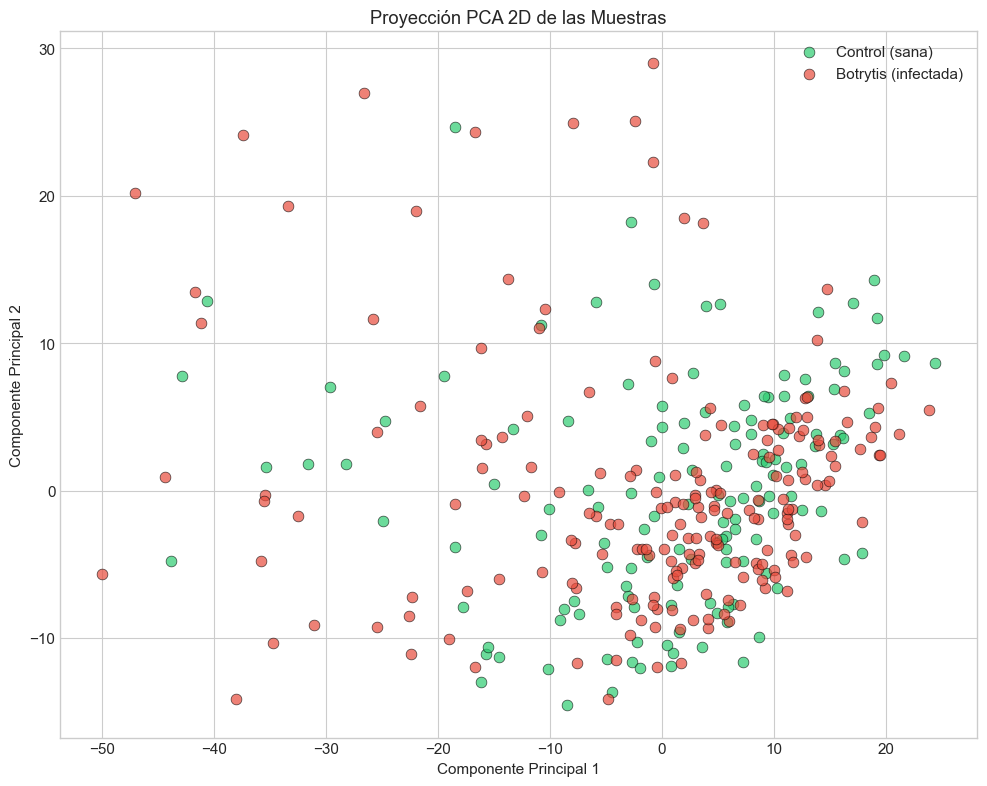

✓ Guardada: pca_proyeccion_2d.png


In [6]:
X_pca_2d, _, _ = apply_pca(X_train_scaled, X_test_scaled, n_components=2)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#2ecc71', '#e74c3c']
labels = ['Control (sana)', 'Botrytis (infectada)']

for i, (color, label) in enumerate(zip(colors, labels)):
    mask = y_train == i
    ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], c=color, label=label, alpha=0.7, edgecolors='black', linewidth=0.5, s=60)

ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_title('Proyección PCA 2D de las Muestras')
ax.legend()

plt.tight_layout()
plt.savefig(GRAFICAS_PATH / 'pca_proyeccion_2d.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Guardada: pca_proyeccion_2d.png")

## 6. Gráfica: Feature Importance (XGBoost)

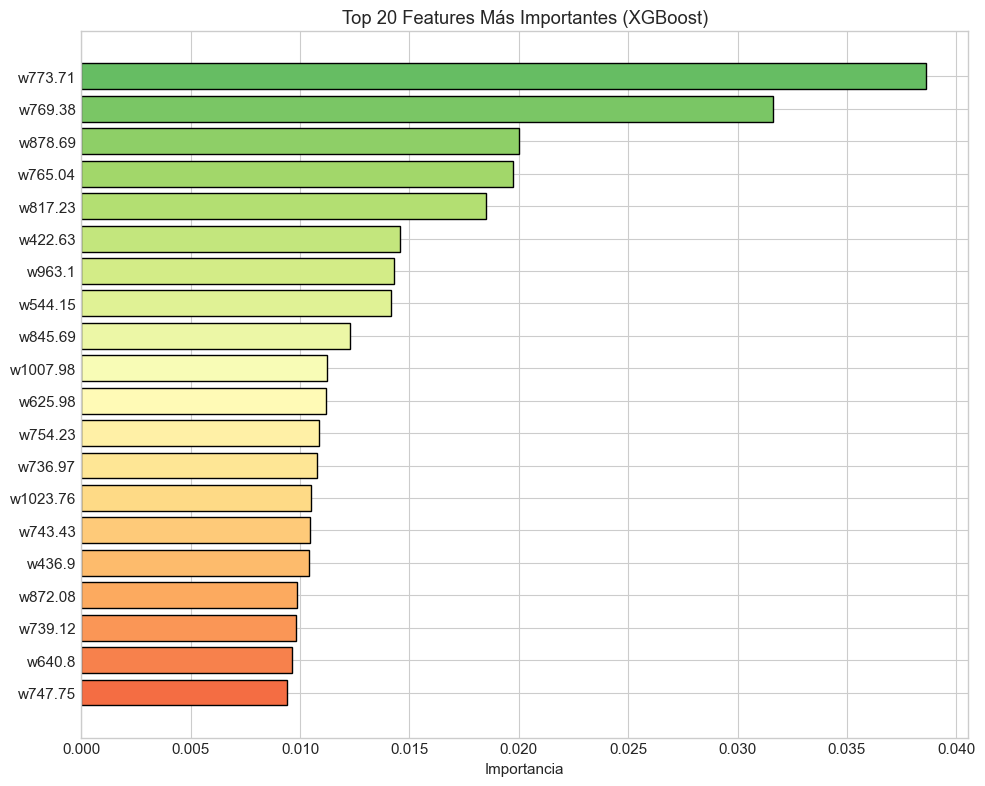

✓ Guardada: feature_importance_xgboost.png


In [7]:
model_xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss')
model_xgb.fit(X_train_scaled, y_train)

importance = model_xgb.feature_importances_
top_n = 20
indices = np.argsort(importance)[-top_n:]

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, top_n))

ax.barh(range(top_n), importance[indices], color=colors, edgecolor='black')
ax.set_yticks(range(top_n))
ax.set_yticklabels([feature_cols[i] for i in indices])
ax.set_xlabel('Importancia')
ax.set_title('Top 20 Features Más Importantes (XGBoost)')

plt.tight_layout()
plt.savefig(GRAFICAS_PATH / 'feature_importance_xgboost.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Guardada: feature_importance_xgboost.png")

## 7. Gráfica: Matrices de Confusión

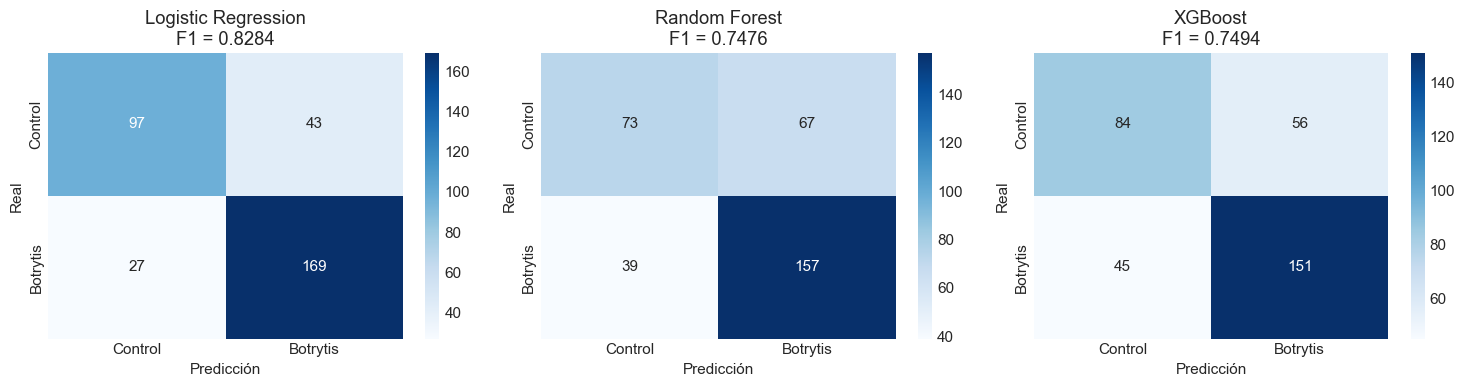

✓ Guardada: matrices_confusion_modelos.png


In [8]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss')
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for ax, (name, model) in zip(axes, models.items()):
    y_pred = cross_val_predict(model, X_train_scaled, y_train, cv=skf)
    cm = confusion_matrix(y_train, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Control', 'Botrytis'], yticklabels=['Control', 'Botrytis'])
    
    f1 = f1_score(y_train, y_pred)
    ax.set_title(f'{name}\nF1 = {f1:.4f}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.savefig(GRAFICAS_PATH / 'matrices_confusion_modelos.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Guardada: matrices_confusion_modelos.png")

## 8. Resumen de Gráficas Generadas

In [9]:
print("Gráficas generadas en:", GRAFICAS_PATH)
print("\nArchivos:")
for f in sorted(GRAFICAS_PATH.glob('*.png')):
    print(f"  - {f.name}")

print("\n✓ Listo para incluir en el documento LaTeX!")

Gráficas generadas en: c:\Users\the_y\OneDrive\Escritorio\UNI\4º\1er cuatrimestre\IN\Practicas\P3\docs\graficas

Archivos:
  - comparacion_modelos_fase1.png
  - correlacion_fluorescencia.png
  - diferencia_espectral.png
  - distribucion_clases.png
  - espectros_promedio.png
  - feature_importance_xgboost.png
  - fluorescencia_boxplot.png
  - fluorescencia_distribucion.png
  - matrices_confusion_modelos.png
  - pairplot_fluorescencia.png
  - pca_exploratorio.png
  - pca_proyeccion_2d.png
  - pca_varianza_explicada.png

✓ Listo para incluir en el documento LaTeX!
